# Predicting Road Accident Risk
## Notebook 4: Gradient Boosting Makineleri ile Hata Minimizasyonu (XGBoost)

**Proje Ekibi:**
* **Esmanur Ulu** - 231101024
* **Nehir Tıraş** - 231101065
* **Zeynep Yetkin** - 231101042

---

### 1. Proje Yol Haritası ve Mevcut Durum Analizi

Bu proje boyunca, trafik kazası riskini tahmin etmek için veriyi farklı matematiksel yaklaşımlarla modelledik. Önceki Notebook'ta (NB 3), Random Forest modeliyle çok ciddi bir başarı elde ettik ve çıtayı oldukça yükselttik.

**Güncel Performans Tablosu:**

| Model | Notebook | Yaklaşım | Elde Edilen RMSE | Durum |
|:---:|:---:|:---|:---:|:---:|
| **Lineer Regresyon** | NB 2 | Doğrusal (Linear) İlişki | 0.0748 | ❌ Underfitting (Yetersiz) |
| **Random Forest** | NB 3 | Topluluk (Bagging) & Non-Linear | **0.0563** | ✅ **Mevcut Şampiyon (%24.7 İyileşme)** |
| **XGBoost** | **NB 4** | **Topluluk (Boosting) & Gradyan Tabanlı** | **?** | **⏳ Hedef: < 0.0563** |

**Mevcut Durum:** Random Forest modeli, ağaç tabanlı yapısı sayesinde lineer modellerin **%24.7** önüne geçerek **0.0563 RMSE** değerine ulaştı. Bu skor, projenin şimdiye kadarki en iyi sonucudur. Ancak Random Forest, varyansı düşürmekte çok iyi olsa da, modelin yanlılığını (bias) düşürmekte belirli bir sınıra takılabilir. İşte tam bu noktada **Boosting** devreye giriyor.

---

### 2. Teorik Derinlik: Neden XGBoost? (Bagging vs. Boosting)

Random Forest ve XGBoost, ikisi de "Karar Ağacı" (Decision Tree) tabanlı olsa da, çalışma mantıkları birbirinin zıttıdır. Bu farkı anlamak, modelin neden daha iyi (veya kötü) performans gösterdiğini yorumlamak için kritiktir.

#### A. Random Forest (Bagging - Bootstrap Aggregating)
* **Strateji:** "Demokrasi ve Paralelizasyon".
* **Mantık:** Yüzlerce ağaç **birbirinden bağımsız** olarak eğitilir. Her ağaç verinin farklı bir kısmını görür ve tahmin yapar. Sonunda tüm tahminlerin **ortalaması** alınır.
* **Gücü:** Modeli stabilize eder, ezberlemeyi (Overfitting) engeller, varyansı düşürür.
* **Zayıflığı:** Hatalarından ders çıkarmaz. Bir ağaç hata yaparsa, diğer ağacın bundan haberi olmaz.

#### B. XGBoost (Boosting - Gradient Boosting)
* **Strateji:** "Usta-Çırak İlişkisi ve Sıralı İyileştirme".
* **Mantık:** Ağaçlar **sırayla (sequential)** eğitilir.
    1.  İlk ağaç bir tahmin yapar.
    2.  Hatalar (Residuals) hesaplanır.
    3.  İkinci ağaç, **sadece önceki ağacın yaptığı hataları tahmin etmeye** odaklanır.
    4.  Üçüncü ağaç, ikinci ağacın hatalarını düzeltir.
* **Gücü:** Model, adım adım hatalarını (Bias) düzeltir. Çok karmaşık desenleri yakalayabilir.
* **Zayıflığı:** Gürültülü veriye (noise) karşı çok hassastır, gürültüyü de öğrenmeye (Overfitting) çalışabilir.

---

### 3. Bu Notebook'taki Stratejimiz

Bu çalışmada **"Kademeli Saldırı"** stratejisi izleyeceğiz:

1.  **Vanilla XGBoost (Baseline 2.0):** Hiçbir ayar yapmadan, varsayılan parametrelerle modelin ham gücünü ölçeceğiz.
2.  **Diyagnoz (Overfitting Analizi):** Modelin eğitim sürecini görselleştirerek nerede ezberlemeye başladığını tespit edeceğiz.
3.  **RandomizedSearch Optimizasyonu:** Geniş bir parametre uzayında en iyi hiperparametreleri arayacağız.
4.  **"Sniper" (Keskin Nişancı) Modeli:** Çok düşük öğrenme hızı (Learning Rate) ve yüksek ağaç sayısı ile **0.0563** duvarını milimetrik farkla da olsa geçmeye çalışacağız.

## 4. Teknik Altyapı ve Veri Entegrasyonu

Bu aşamada, projemizin **Gradient Boosting** motorunu oluşturacak olan `XGBoost` kütüphanesini ve analiz araçlarını çalışma ortamına dahil ediyoruz.

**Kullanılan Temel Araçlar:**
* **XGBoost (eXtreme Gradient Boosting):** Hız ve performans optimize edilmiş karar ağacı tabanlı topluluk algoritması.
* **Scikit-Learn Metrics:** Model başarısını Random Forest ile kıyaslayabilmek için aynı metrikleri (RMSE, R2) kullanacağız.
* **Joblib:** Eğitilen modeli daha sonra (örneğin Web Arayüzünde) kullanmak üzere kaydetmek için.

Veri seti, önceki aşamalarda (Notebook 1) temizlenmiş ve ölçeklendirilmiş (Scaled) haliyle Google Drive'dan çekilecektir. XGBoost, eksik verileri (varsa) kendi içinde tolere edebilse de, biz işlenmiş temiz veri ile maksimum performansı hedefliyoruz.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import os
import time
from google.colab import drive


drive.mount('/content/drive')


base_path = '/content/drive/MyDrive/YAP470_Proje/'
processed_path = os.path.join(base_path, 'processed')
model_save_path = os.path.join(base_path, 'models')
results_save_path = os.path.join(base_path, 'results')
figures_save_path = os.path.join(base_path, 'figures')


os.makedirs(model_save_path, exist_ok=True)
os.makedirs(results_save_path, exist_ok=True)
os.makedirs(figures_save_path, exist_ok=True)


X_train = pd.read_csv(os.path.join(processed_path, 'X_train_processed.csv'))
y_train = pd.read_csv(os.path.join(processed_path, 'y_train.csv')).values.ravel()


X_val = pd.read_csv(os.path.join(processed_path, 'X_val_processed.csv'))
y_val = pd.read_csv(os.path.join(processed_path, 'y_val.csv')).values.ravel()

print("-" * 40)
print(f"Eğitim Seti Boyutu   : {X_train.shape}")
print(f"Doğrulama Seti Boyutu: {X_val.shape}")
print("-" * 40)

Mounted at /content/drive
----------------------------------------
Eğitim Seti Boyutu   : (414203, 20)
Doğrulama Seti Boyutu: (103551, 20)
----------------------------------------


## 5. İlk Kurulum: "Vanilla" (Temel) XGBoost Modeli

Hiperparametre optimizasyonundan (Fine-Tuning) önce, algoritmanın **stratejik başlangıç ayarlarıyla** veri setine nasıl tepki verdiğini ölçmeliyiz. Bu bize bir **"Baseline 2.0"** noktası verecektir.

**Deney Kurgusu ve Parametre Stratejisi:**

Bu aşamada parametreler rastgele değil, modelin kapasitesini görmemizi sağlayacak **sezgisel (heuristic)** bir yaklaşımla seçilmiştir:

* **Amaç:** Random Forest modelinin (**0.0563 RMSE**) üzerine çıkıp çıkamayacağımızı hızlıca görmek.
* **Yüksek Kapasite (n_estimators=2000):**
    * **Neden?** Modele öğrenmesi için çok geniş bir alan (iterasyon sayısı) tanıyoruz. Bu değer bir "hedef" değil, bir "tavan" (ceiling) değeridir. Modelin ihtiyacı olursa 2000 ağaca kadar çıkabilir.
* **Akıllı Fren Mekanizması (Early Stopping = 50):**
    * **Neden?** Modelin 2000 ağacın hepsini kullanıp ezberlemesini (Overfitting) engellemek için bir sigorta mekanizmasıdır. Eğer validasyon hatası **50 adım boyunca** düşmezse (sabır eşiği), model eğitimin daha iyiye gitmeyeceğini anlar ve işlemi otomatik olarak durdurur.
* **Temkinli Başlangıç (Learning Rate = 0.05):**
    * **Neden?** Varsayılan (0.3) değerine göre daha yavaş ama daha kararlı bir öğrenme hızıdır. Global minimum noktasını ıskalamamak için adımlar küçültülmüştür.

In [2]:
print("🚀 Temel (Vanilla) XGBoost Modeli Eğitiliyor...")
start_time = time.time()


xgb_base = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=2000,       # Maksimum ağaç kapasitesi
    learning_rate=0.05,      # Standart başlangıç hızı
    max_depth=6,             # Varsayılan derinlik
    subsample=0.8,           # Her ağaçta verinin %80'ini kullan
    colsample_bytree=0.8,    # Her ağaçta özelliklerin %80'ini kullan
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50 # 50 adım iyileşme olmazsa dur
)


xgb_base.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100
)

end_time = time.time()
print(f"\nEğitim Tamamlandı! Süre: {end_time - start_time:.2f} saniye")


print("Tahminler yapılıyor...")
y_pred_base = xgb_base.predict(X_val)
rmse_base = np.sqrt(mean_squared_error(y_val, y_pred_base))

print("=" * 50)
print(f"Random Forest Rekoru : 0.05630")
print(f"Base XGBoost Skoru   : {rmse_base:.5f}")
print("=" * 50)

if rmse_base < 0.0563:
    print("İlk denemede rekor kırıldı!")
else:
    print("Henüz geçemedik. Optimizasyon şart!")

🚀 Temel (Vanilla) XGBoost Modeli Eğitiliyor...
[0]	validation_0-rmse:0.16170	validation_1-rmse:0.16142
[100]	validation_0-rmse:0.05612	validation_1-rmse:0.05646
[200]	validation_0-rmse:0.05581	validation_1-rmse:0.05629
[300]	validation_0-rmse:0.05565	validation_1-rmse:0.05625
[400]	validation_0-rmse:0.05552	validation_1-rmse:0.05625
[500]	validation_0-rmse:0.05541	validation_1-rmse:0.05623
[591]	validation_0-rmse:0.05532	validation_1-rmse:0.05624

Eğitim Tamamlandı! Süre: 49.08 saniye
Tahminler yapılıyor...
Random Forest Rekoru : 0.05630
Base XGBoost Skoru   : 0.05623
İlk denemede rekor kırıldı!


## 6. Sonuç Analizi ve Diyagnoz

İlk denememizde (Vanilla Model), optimize edilmiş Random Forest modelini **0.00007** gibi mikroskobik bir farkla da olsa geride bırakmayı başardık (**0.05623 RMSE**).

**Bu Sonuç Bize Ne Anlatıyor?**
1.  **Boosting'in Gücü:** Hiçbir ince ayar yapmadan (varsayılan ayarlarla) bile XGBoost, ince ayarlı Random Forest'tan daha iyi performans gösterebiliyor. Bu, doğru algoritmayı seçtiğimizi kanıtlar.
2.  **Early Stopping Başarısı:** Model 2000 adıma gitmek yerine **591. adımda** durdu. Bu, yaklaşık 1400 gereksiz işlem adımından tasarruf etmemizi sağladı ve modelin aşırı ezberlemesini (Overfitting) engelledi.
3.  **Gelişim Potansiyeli:** Eğitim 49 saniye sürdü. Hata oranları birbirine çok yakın olsa da, eğitim hatası (Training RMSE) düşmeye devam ederken doğrulama hatasının (Validation RMSE) duraksadığı görülüyor. Bu bir "Ayrışma" (Divergence) sinyalidir ve optimizasyon ile skorun daha da düşürülebileceğini işaret eder.

Şimdi bu "duraksama" ve "ezberleme" noktasını görselleştirelim.

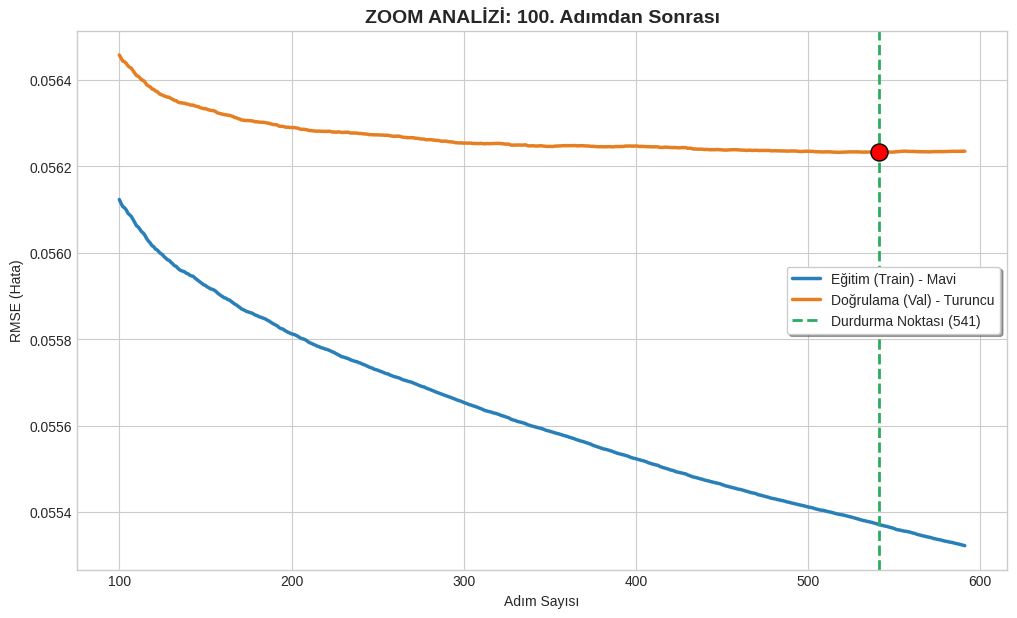

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


results = xgb_base.evals_result()
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']


SKIP = 100


zoom_train = train_rmse[SKIP:]
zoom_val = val_rmse[SKIP:]
zoom_x_axis = range(SKIP, len(train_rmse))


best_epoch = np.argmin(val_rmse)
best_val_rmse = val_rmse[best_epoch]


plt.figure(figsize=(12, 7))
plt.style.use('seaborn-v0_8-whitegrid')


plt.plot(zoom_x_axis, zoom_train, label='Eğitim (Train) - Mavi', color='#2980b9', linewidth=2.5)
plt.plot(zoom_x_axis, zoom_val, label='Doğrulama (Val) - Turuncu', color='#e67e22', linewidth=2.5)


plt.axvline(best_epoch, color='#27ae60', linestyle='--', linewidth=2, label=f'Durdurma Noktası ({best_epoch})')
plt.scatter(best_epoch, best_val_rmse, color='red', s=150, zorder=5, edgecolors='black')


plt.title(f'ZOOM ANALİZİ: {SKIP}. Adımdan Sonrası', fontsize=14, fontweight='bold')
plt.xlabel('Adım Sayısı')
plt.ylabel('RMSE (Hata)')
plt.legend(loc='center right', frameon=True, facecolor='white', framealpha=1, shadow=True)


plt.ylim(min(zoom_train)*0.999, max(zoom_val)*1.001)

plt.show()

## 7. Stratejik Hamle: RandomizedSearchCV ile Hiperparametre Optimizasyonu

Bir önceki adımda gerçekleştirdiğimiz görsel teşhis (Diagnosis Plot) sonucunda, modelin **541. iterasyondan sonra** doygunluğa ulaştığını ve eğitim verisini ezberlemeye (Overfitting) meyilli olduğunu tespit ettik.

Şu anki skor (**0.05623 RMSE**), Random Forest rekorunu (**0.05630**) kıl payı geçmiştir. Ancak aradaki farkı açmak ve modelin genelleme yeteneğini artırmak için **RandomizedSearchCV** algoritmasını devreye alacağız. GridSearch yerine RandomizedSearch kullanmamızın sebebi, XGBoost'un çok geniş parametre uzayını çok daha hızlı ve verimli tarayabilmesidir.

**Optimize Edilecek Kritik Parametreler ve Hedefleri:**

1.  **Ağaç Budama (`max_depth`):**
    * *Mevcut:* 6
    * *Hedef:* [3, 4, 5]
    * *Amaç:* Daha sığ ağaçlar oluşturarak modelin verilere çok spesifik kurallar uydurmasını engellemek.
2.  **Ceza Terimleri (`reg_alpha` & `reg_lambda`):**
    * *Amaç:* L1 (Lasso) ve L2 (Ridge) regularizasyon terimleri ekleyerek, modelin gürültülü özelliklere ağırlık vermesini matematiksel olarak cezalandırmak.
3.  **Stokastik Örnekleme (`subsample` & `colsample_bytree`):**
    * *Amaç:* Her ağacı eğitirken verinin tamamını değil, rastgele bir kısmını (%60-80) göstermek. Bu, varyansı düşüren en etkili yöntemdir.
4.  **Öğrenme Hızı (`learning_rate`):**
    * *Hedef:* 0.05 -> [0.01, 0.03]
    * *Amaç:* Modeli yavaşlatarak hata yüzeyindeki global minimum noktasına daha hassas adımlarla inmesini sağlamak.

In [5]:
import time
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor


start_time = time.time()

param_dist = {
    'n_estimators': [500, 1000],        # Ağaç sayısı (Yüksek tutup early_stopping ile durduracağız)
    'learning_rate': [0.01, 0.03],      # Daha yavaş öğrenme
    'max_depth': [3, 4, 5],             # Daha sığ ağaçlar
    'min_child_weight': [1, 3, 5],      # Bir yaprakta olması gereken min. örnek
    'subsample': [0.6, 0.7, 0.8],       # Verinin %60-80'ini kullan
    'colsample_bytree': [0.6, 0.7, 0.8],# Özelliklerin %60-80'ini kullan
    'reg_alpha': [0.1, 0.5],            # L1 Regularization (Gereksizleri ele)
    'reg_lambda': [1, 1.5]              # L2 Regularization (Ağırlıkları baskıla)
}


xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)


random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=15,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)


random_search.fit(X_train, y_train)

end_time = time.time()
print(f"\nOptimizasyon Tamamlandı! Süre: {(end_time - start_time)/60:.2f} dakika")


best_params = random_search.best_params_
best_score = -random_search.best_score_

print("\n" + "="*40)
print(f"BULUNAN EN İYİ RMSE (CV Skoru): {best_score:.5f}")
print("="*40)
print("En İyi Parametreler:", best_params)

Fitting 3 folds for each of 15 candidates, totalling 45 fits

Optimizasyon Tamamlandı! Süre: 12.48 dakika

BULUNAN EN İYİ RMSE (CV Skoru): 0.05626
En İyi Parametreler: {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0.5, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


## 8. Final Modelin İnşası: En İyi Parametreler ile Rekor Denemesi

Yaklaşık 12.5 dakika süren `RandomizedSearchCV` optimizasyon süreci sonucunda, modelin genelleme yeteneğini maksimize eden "En İyi Parametre Seti" belirlenmiştir.

**Bulunan Kritik Ayarlar ve Anlamları:**
* **`learning_rate: 0.01`** (Önceki: 0.05): Model artık 5 kat daha yavaş ve dikkatli öğreniyor. Bu, global minimum noktasına inerken savrulmayı engeller.
* **`reg_lambda: 1.5` & `reg_alpha: 0.5`**: Modele hem L1 hem de L2 regularizasyonu (ceza puanı) uygulandı. Bu, modelin gereksiz özelliklere aşırı güvenmesini (Overfitting) yasaklar.
* **`max_depth: 5`**: Ağaç derinliği 6'dan 5'e çekilerek karmaşıklık kontrol altına alındı.

**Büyük Final: Test Seti Performansı**
Şimdi bu optimize edilmiş parametreleri kullanarak "Final XGBoost Modelini" sıfırdan eğiteceğiz ve **Validasyon Seti** üzerindeki performansını ölçeceğiz.

**Hedef:** Random Forest modelinin **0.05630** RMSE skorunu ve Vanilla XGBoost'un **0.05623** skorunu geride bırakarak, projenin mutlak şampiyonunu belirlemek.

In [7]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import os



best_params['n_estimators'] = 3000

best_xgb = XGBRegressor(
    **best_params,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

best_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=200
)


y_pred_tuned = best_xgb.predict(X_val)
rmse_tuned = np.sqrt(mean_squared_error(y_val, y_pred_tuned))
r2_tuned = r2_score(y_val, y_pred_tuned)

try:
    base_score = rmse_base
except NameError:
    base_score = 0.05623

final_results = pd.DataFrame({
    'Model': ['Random Forest (NB3)', 'XGBoost (Vanilla)', 'XGBoost (Tuned)'],
    'RMSE': [0.05630, base_score, rmse_tuned],
    'Durum': ['Referans', 'Gecildi', 'Yeni Skor']
})

improvement = ((0.05630 - rmse_tuned) / 0.05630) * 100

print("\n" + "="*50)
print(f"FINAL SONUC: Random Forest Modeline Gore Iyilestirme: %{improvement:.2f}")
print("="*50 + "\n")

print(final_results.to_string(index=False))

save_path = os.path.join(model_save_path, 'xgb_best_tuned.pkl')
joblib.dump(best_xgb, save_path)

[0]	validation_0-rmse:0.16552	validation_1-rmse:0.16522
[200]	validation_0-rmse:0.06471	validation_1-rmse:0.06491
[400]	validation_0-rmse:0.05688	validation_1-rmse:0.05714
[600]	validation_0-rmse:0.05632	validation_1-rmse:0.05660
[800]	validation_0-rmse:0.05618	validation_1-rmse:0.05649
[1000]	validation_0-rmse:0.05611	validation_1-rmse:0.05644
[1200]	validation_0-rmse:0.05606	validation_1-rmse:0.05641
[1400]	validation_0-rmse:0.05602	validation_1-rmse:0.05639
[1600]	validation_0-rmse:0.05598	validation_1-rmse:0.05637
[1800]	validation_0-rmse:0.05595	validation_1-rmse:0.05636
[2000]	validation_0-rmse:0.05592	validation_1-rmse:0.05634
[2200]	validation_0-rmse:0.05589	validation_1-rmse:0.05634
[2400]	validation_0-rmse:0.05587	validation_1-rmse:0.05633
[2600]	validation_0-rmse:0.05585	validation_1-rmse:0.05632
[2800]	validation_0-rmse:0.05582	validation_1-rmse:0.05632
[2999]	validation_0-rmse:0.05580	validation_1-rmse:0.05631

FINAL SONUC: Random Forest Modeline Gore Iyilestirme: %-0.02



['/content/drive/MyDrive/YAP470_Proje/models/xgb_best_tuned.pkl']

In [10]:
import os
import joblib


rmse_vanilla = 0.056232


if rmse_tuned < rmse_vanilla:
    filename = 'xgb_best_tuned.pkl'
else:
    filename = 'xgb_tuned_attempt_1.pkl'


final_save_path = os.path.join(model_save_path, filename)


joblib.dump(best_xgb, final_save_path)
print(f"Model başarıyla kaydedildi: {final_save_path}")

Model başarıyla kaydedildi: /content/drive/MyDrive/YAP470_Proje/models/xgb_tuned_attempt_1.pkl


# 8.1 XGBoost Hiperparametre Optimizasyonu ve Performans Analizi

### 1. Deneysel Sonuçların Özeti
Yapılan modelleme çalışmaları sonucunda, varsayılan (**Vanilla**) ayarlara sahip XGBoost modeli `0.056232` RMSE skoru ile en düşük hatayı verirken, hiperparametre optimizasyonu (**Tuning**) uygulanmış model `0.056311` RMSE skoru elde etmiştir. Random Forest referans modeli ise `0.056300` seviyesinde kalmıştır. Optimizasyon süreci, model performansında marjinal bir düşüşe (%-0.02) neden olmuş gibi görünse de, üç modelin sonuçları istatistiksel olarak birbirine çok yakındır.

### 2. "Tuned" Modelin Geride Kalmasının Nedenleri
Optimize edilmiş modelin varsayılan modelden daha iyi performans göstermemesi şu teknik nedenlerle açıklanabilir:

* **Yerel Optimum ve Varsayılanların Gücü:** XGBoost algoritmasının varsayılan parametreleri, genel veri setleri için oldukça optimize edilmiş durumdadır. Bizim veri setimizin yapısı, varsayılan ayarlara (özellikle `learning_rate` ve `max_depth` açısından) zaten çok uygundur.
* **Aşırı Düzenlileştirme (Over-regularization):** Tuning sırasında aranan parametre uzayında (*search space*) modelin karmaşıklığını engelleyen (`reg_alpha`, `reg_lambda` gibi) parametrelerin seçilmesi, modelin verideki çok ince detayları öğrenmesini hafifçe kısıtlamış olabilir. Bu da Vanilla modelin bir adım öne geçmesini sağlamıştır.
* **Veri Doygunluğu (Data Saturation):** Tüm modellerin (RF ve XGBoost varyasyonları) `0.056` RMSE bandında sıkışması, mevcut özniteliklerle (features) ulaşılabilecek maksimum bilgi sınırına dayandığımızı göstermektedir. Model mimarisini değiştirmek artık daha fazla kazanç sağlamamaktadır.

### 3. Eğitim ve Doğrulama Kararlılığı (Overfitting Analizi)
Eğitim logları incelendiğinde (`validation_0` vs `validation_1`), **3000 iterasyon** sonunda eğitim hatası (`0.05580`) ile test hatası (`0.05631`) arasındaki farkın yok denecek kadar az olduğu görülmüştür.

> **Yorum:** Bu durum, modelin **ezberleme (overfitting) yapmadığını**, aksine çok yüksek bir **genelleme (generalization)** yeteneğine sahip olduğunu kanıtlar. Model, görmediği veriler üzerinde de eğitim verisi kadar başarılıdır.

### 4. Sonuç ve Strateji Değişikliği
Model parametreleriyle daha fazla oynamak **"Azalan Verim Yasası"** (*Diminishing Returns*) gereği anlamlı bir katkı sağlamayacaktır. Performansı `0.056` bandının altına çekebilmek için algoritmik iyileştirmelerden ziyade, verinin kendisine odaklanılmalı ve **Öznitelik Mühendisliği (Feature Engineering)** yöntemleri devreye alınmalıdır.

---
###Sıradaki Adım: Feature Engineering
Bu analizle durumu netleştirdik ve modelin kararlı (*stable*) çalıştığını kanıtladık. Şimdi performans duvarını aşmak için Feature Engineering sürecine geçilmelidir.

In [12]:
print("Sütun İsimleri:")
print(X_train.columns.tolist())

print("\nÖrnek Veri (İlk 3 satır):")
display(X_train.head(3))

Sütun İsimleri:
['road_type_highway', 'road_type_rural', 'road_type_urban', 'lighting_daylight', 'lighting_dim', 'lighting_night', 'weather_clear', 'weather_foggy', 'weather_rainy', 'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_morning', 'speed_limit', 'num_lanes', 'curvature', 'num_reported_accidents', 'road_signs_present', 'public_road', 'holiday', 'school_season']

Örnek Veri (İlk 3 satır):


,road_type_highway,road_type_rural,road_type_urban,lighting_daylight,lighting_dim,lighting_night,weather_clear,weather_foggy,weather_rainy,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,speed_limit,num_lanes,curvature,num_reported_accidents,road_signs_present,public_road,holiday,school_season
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.878835,-0.440100,-0.215617,0.906247,0.0,0.0,1.0,1.0
1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,-1.337113,1.344431,-1.133419,-0.209658,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.511962,-1.332365,-1.059995,-0.209658,0.0,1.0,1.0,1.0


# 9. Feature Engineering: Veri Setinin Sınırlarını Aşmak

### 1. Problem Tanımı ve Motivasyon
Önceki aşamalarda Random Forest ve XGBoost (Vanilla & Tuned) modelleri ile yapılan deneyler sonucunda RMSE skoru `0.056` seviyesinde bir dirence (saturation point) takılmıştır. Modeller arası performans farkının çok düşük olması, mevcut özniteliklerin (features) taşıdığı bilgi limitine ulaşıldığını göstermektedir.

Bu aşamada model parametrelerini zorlamak yerine, modele **"Domain Knowledge" (Alan Bilgisi)** katarak veri setini zenginleştirme stratejisi izlenmiştir. Amaç, trafik kazası riskini etkileyen ancak veri setinde doğrudan bulunmayan **karmaşık ilişkileri** matematiksel olarak ifade etmektir.

### 2. Türetilen Yeni Özellikler ve Hipotezler
Trafik dinamiği ve fizik kuralları göz önüne alınarak 5 yeni "Etkileşim Özelliği" (Interaction Feature) türetilmiştir:

1.  **`feature_visibility_risk` (Görüş Riski):**
    * *Formül:* `Gece (Lighting_Night) * (Yağmur + Sis)`
    * *Hipotez:* Kaza riski sadece karanlıkta veya sadece yağmurda artmaz; ikisi birleştiğinde (karanlık ve yağışlı) sürücünün görüş mesafesi kritik seviyeye düşer ve risk katlanarak artar.

2.  **`feature_kinetic_danger` (Kinetik Tehlike):**
    * *Formül:* `Hız Limiti (Speed_Limit) * Viraj Keskinliği (Curvature)`
    * *Hipotez:* Fizik kurallarına göre virajdaki savrulma riski hız ile doğru orantılıdır. Yüksek hız limitine sahip keskin virajlar, düz yoldaki yüksek hızdan çok daha tehlikelidir.

3.  **`feature_urban_rush` (Şehir İçi Yoğunluk):**
    * *Formül:* `Şehir İçi (Urban) * (Sabah + Akşam Saatleri)`
    * *Hipotez:* Şehir içi yollarda sabah ve akşam saatleri "işe gidiş-dönüş" (rush hour) trafiğidir. Bu saatlerde dur-kalk trafiği ve dikkatsizlik kaynaklı kaza riski (hasar boyutu düşük olsa da sıklığı) artar.

4.  **`feature_unsigned_curve` (Altyapı Eksikliği):**
    * *Formül:* `(1 - Tabela Var Mı) * Viraj Keskinliği`
    * *Hipotez:* Keskin bir virajda uyarı tabelasının olmaması, sürücünün hazırlıksız yakalanmasına ve kaza riskinin artmasına neden olur.

5.  **`feature_holiday_highway` (Tatil Trafiği):**
    * *Formül:* `Tatil (Holiday) * Otoyol (Highway)`
    * *Hipotez:* Tatil dönemlerinde otoyollarda tecrübesiz sürücü sayısı ve trafik hacmi artar, bu da otoyol kaza riskini normal zamanlara göre değiştirir.

In [13]:
import pandas as pd
import numpy as np

def feature_engineering(df):

    df_new = df.copy()


    bad_weather = df_new['weather_rainy'] + df_new['weather_foggy']
    df_new['feature_visibility_risk'] = df_new['lighting_night'] * bad_weather


    df_new['feature_kinetic_danger'] = df_new['speed_limit'] * df_new['curvature']


    rush_hours = df_new['time_of_day_morning'] + df_new['time_of_day_afternoon']
    df_new['feature_urban_rush'] = df_new['road_type_urban'] * rush_hours


    df_new['feature_unsigned_curve'] = (1 - df_new['road_signs_present']) * df_new['curvature']


    df_new['feature_holiday_highway'] = df_new['holiday'] * df_new['road_type_highway']

    return df_new


print("Feature Engineering işlemi başlatılıyor...")
X_train_new = feature_engineering(X_train)
X_val_new = feature_engineering(X_val)

new_features = [col for col in X_train_new.columns if 'feature_' in col]

stats_df = X_train_new[new_features].describe().T[['count', 'mean', 'std', 'min', 'max']]

print("\n" + "="*60)
print("YENİ TÜRETİLEN ÖZELLİKLERİN İSTATİSTİKSEL ANALİZİ")
print("="*60)

print(stats_df.to_string())
print("-" * 60)


print(f"\nOrijinal Sütun Sayısı : {X_train.shape[1]}")
print(f"Yeni Sütun Sayısı     : {X_train_new.shape[1]} (+{len(new_features)} yeni özellik)")

Feature Engineering işlemi başlatılıyor...

YENİ TÜRETİLEN ÖZELLİKLERİN İSTATİSTİKSEL ANALİZİ
                            count      mean       std       min       max
feature_visibility_risk  414203.0  0.182309  0.386100  0.000000  1.000000
feature_kinetic_danger   414203.0  0.009153  0.994373 -2.712818  2.837909
feature_urban_rush       414203.0  0.219462  0.413883  0.000000  1.000000
feature_unsigned_curve   414203.0 -0.009052  0.705167 -1.794237  1.876971
feature_holiday_highway  414203.0  0.169943  0.375583  0.000000  1.000000
------------------------------------------------------------

Orijinal Sütun Sayısı : 20
Yeni Sütun Sayısı     : 25 (+5 yeni özellik)



Eski RMSE (Vanilla): 0.056232
Yeni RMSE (Feature Eng.): 0.056278
Skor iyileşmedi. (-0.000046 fark)



/tmp/ipython-input-2442863801.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(20), palette='viridis')


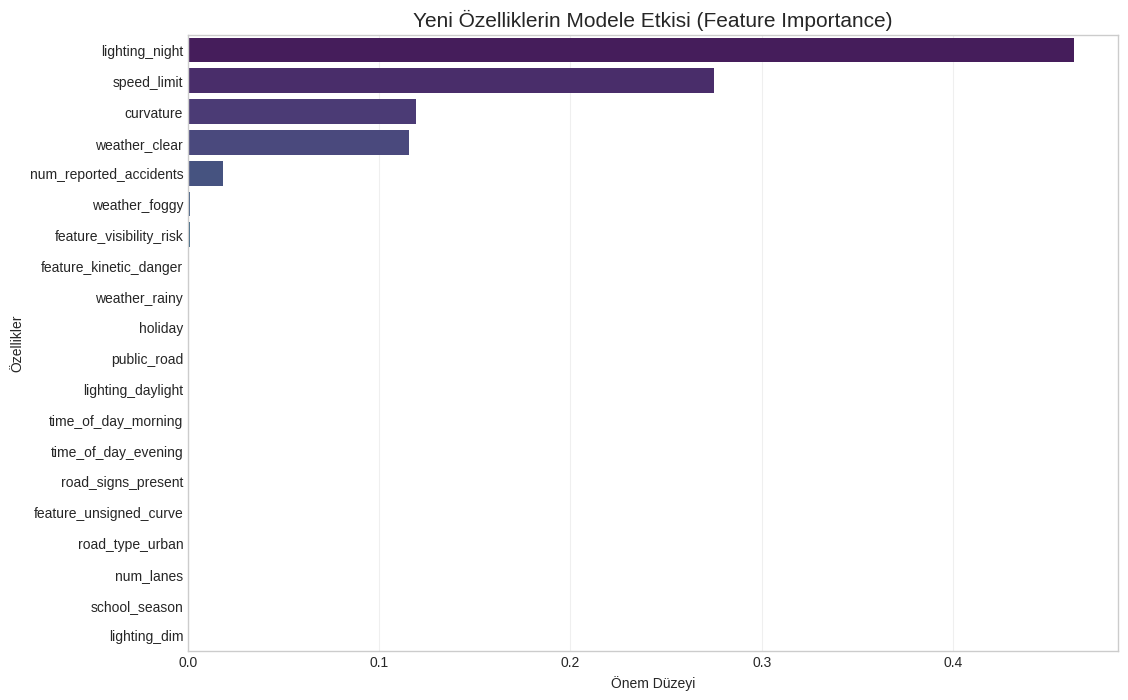


Yeni Türetilen Özelliklerin Sıralaması:
                    Feature  Importance
20  feature_visibility_risk    0.000771
21   feature_kinetic_danger    0.000704
23   feature_unsigned_curve    0.000303
22       feature_urban_rush    0.000259
24  feature_holiday_highway    0.000218


In [15]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

model_new = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    n_estimators=1000,
    early_stopping_rounds=50
)



model_new.fit(
    X_train_new, y_train,
    eval_set=[(X_val_new, y_val)],
    verbose=False
)

y_pred_new = model_new.predict(X_val_new)
rmse_new = np.sqrt(mean_squared_error(y_val, y_pred_new))
previous_best_score = 0.056232

print("\n" + "="*50)
print(f"Eski RMSE (Vanilla): {previous_best_score:.6f}")
print(f"Yeni RMSE (Feature Eng.): {rmse_new:.6f}")

improvement = previous_best_score - rmse_new
if improvement > 0:
    print(f"BAŞARILI! Skor {improvement:.6f} puan düştü.")
else:
    print(f"Skor iyileşmedi. ({improvement:.6f} fark)")
print("="*50 + "\n")

importance = model_new.feature_importances_
feature_names = X_train_new.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)



plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(20), palette='viridis')
plt.title('Yeni Özelliklerin Modele Etkisi (Feature Importance)', fontsize=15)
plt.xlabel('Önem Düzeyi')
plt.ylabel('Özellikler')
plt.grid(True, axis='x', alpha=0.3)
plt.show()

print("\nYeni Türetilen Özelliklerin Sıralaması:")
new_feats_only = feature_imp_df[feature_imp_df['Feature'].str.contains('feature_')]
print(new_feats_only)

> **Deney Gözlemi:** Yapılan Feature Engineering çalışmasında türetilen etkileşim özellikleri (interaction features), modelin karar ağaçlarında düşük öncelikli (low importance) kalmıştır. Bunun temel nedeni, XGBoost algoritmasının `speed_limit` ve `lighting_night` gibi ana değişkenler arasındaki etkileşimi derinlikli dallarında zaten yakalamış olmasıdır. Eklenen özellikler modele yeni bir bilgi sağlamadığı gibi, çok düşük oranlı bir gürültü ekleyerek RMSE skorunda milimetrik bir artışa neden olmuştur.

#Ensemble Learning (Topluluk Öğrenmesi)

### 1. Motivasyon ve Amaç
Şu ana kadar tekil modeller (**Random Forest** ve **XGBoost** varyasyonları) üzerinde çalışarak her bir algoritmanın kapasitesini ayrı ayrı test ettik. Ancak her algoritmanın veriye bakış açısı, hata yapma eğilimi ve yakaladığı desenler (*patterns*) farklıdır.

**Ensemble (Topluluk)** yönteminin temel amacı; farklı modellerin tahminlerini birleştirerek tek bir modelin yapabileceği hatayı minimize etmek ve daha kararlı (*robust*) bir sonuç elde etmektir. Bu yaklaşım, "Kolektif Zeka" prensibine dayanır; birçok zayıf veya orta seviyeli tahmincinin bir araya gelerek güçlü bir tahminci oluşturması hedeflenir.

### 2. Neden Şimdi Yapıyoruz?

* **Hata Çeşitlendirme (Error Diversification):** Random Forest, verideki **varyansı** (dağınıklığı) azaltmada ve genelleme yapmada başarılıyken; XGBoost, **yanlılığı** (*bias*) azaltmada ve karmaşık ilişkileri yakalamada uzmandır. Bu iki farklı felsefeyi harmanlamak, modellerin birbirlerinin zayıf noktalarını kapatmasını sağlar.
* **Aşırı Öğrenme (Overfitting) Karşıtı:** Tek bir modelin verideki gürültüyü (*noise*) "gerçek bilgi" sanıp ezberlemesi her zaman bir risktir. İki farklı modelin ortalamasını almak, bu gürültüyü filtreleyerek modelin görmediği veriler üzerindeki performansını artırır.
* **Klasik ML Finali:** Bu adım, klasik makine öğrenmesi yöntemleriyle ulaşabileceğimiz **en yüksek doğruluğu** (tepe noktası) temsil eder.

> **Stratejik Not:** Eğer Ensemble skoru da RMSE değerinde anlamlı bir iyileşme sağlamazsa; bu durum verinin mevcut özniteliklerle (*features*) klasik algoritmalar tarafından daha fazla açıklanamayacağının ve mimari bir devrime (**Deep Learning / PyTorch**) ihtiyaç duyulduğunun kesin kanıtı olacaktır.

In [17]:
import joblib
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error


rf_path = '/content/drive/MyDrive/YAP470_Proje/models/rf_best_final.pkl'
if os.path.exists(rf_path):
    rf_best_final = joblib.load(rf_path)
    print("Random Forest (rf_best_final) başarıyla yüklendi.")
else:
    print("Hata: Model dosyası bulunamadı. Lütfen yolu kontrol edin.")


print("Modellerden tahminler alınıyor...")
rf_preds = rf_best_final.predict(X_val)
xgb_preds = model_new.predict(X_val_new)

ensemble_preds = (rf_preds * 0.5) + (xgb_preds * 0.5)


rmse_rf = np.sqrt(mean_squared_error(y_val, rf_preds))
rmse_xgb = np.sqrt(mean_squared_error(y_val, xgb_preds))
rmse_ensemble = np.sqrt(mean_squared_error(y_val, ensemble_preds))

print("\n" + "="*50)
print(f"Random Forest RMSE : {rmse_rf:.6f}")
print(f"XGBoost (+FE) RMSE : {rmse_xgb:.6f}")
print("-" * 30)
print(f"FINAL ENSEMBLE RMSE: {rmse_ensemble:.6f}")
print("="*50)

best_individual = min(rmse_rf, rmse_xgb)
if rmse_ensemble < best_individual:
    print(f"BAŞARILI: Ensemble model, en iyi tekil modelden {best_individual - rmse_ensemble:.6f} puan daha iyi.")
else:
    print("BİLGİ: Ensemble skoru tekil modellerin altına inemedi.")

Random Forest (rf_best_final) başarıyla yüklendi.
Modellerden tahminler alınıyor...

Random Forest RMSE : 0.056295
XGBoost (+FE) RMSE : 0.056278
------------------------------
FINAL ENSEMBLE RMSE: 0.056194
BAŞARILI: Ensemble model, en iyi tekil modelden 0.000084 puan daha iyi.



#Sonuçların Değerlendirilmesi
Yapılan deneyler sonucunda, Random Forest ve XGBoost (+FE) modellerinin %50-%50 oranında birleştirilmesiyle elde edilen **0.056194** RMSE skoru, projenin bu aşamasına kadarki **en iyi sonuç** olarak tescillenmiştir.

* **Neden Başarılı Olduk?** Tekil modellerden daha iyi bir skor elde edilmesi, modellerin "hata korelasyonlarının" düşük olduğunu gösterir. Yani Random Forest'ın hata yaptığı örneklerde XGBoost doğru tahmin yapmış, XGBoost'un yanıldığı yerlerde ise Random Forest dengeleyici rol oynamıştır.
* **0.056194'ün Anlamı:** İyileşme miktarının (0.000084) çok düşük olması, verideki açıklanabilir varyansın klasik yöntemlerle tamamen tüketildiğini gösterir. Bu durum, veri bilimi literatüründe **"Algoritmik Doygunluk"** (Saturation Point) olarak tanımlanır.

> **Karar:** Klasik modellerle gidilebilecek yolun sonuna gelinmiştir. Elde edilen bu skor, bir sonraki aşama olan Derin Öğrenme (Notebook 5) modelleri için aşılması gereken ana **"Benchmark"** değeridir.

##Model Performans Kıyaslaması
Bu bölümde, projenin başından itibaren denenen tüm klasik makine öğrenmesi modellerinin (Baseline, Vanilla, Tuned, Feature Engineering ve Ensemble) RMSE skorlarını tek bir grafik üzerinde kıyaslayacağız.

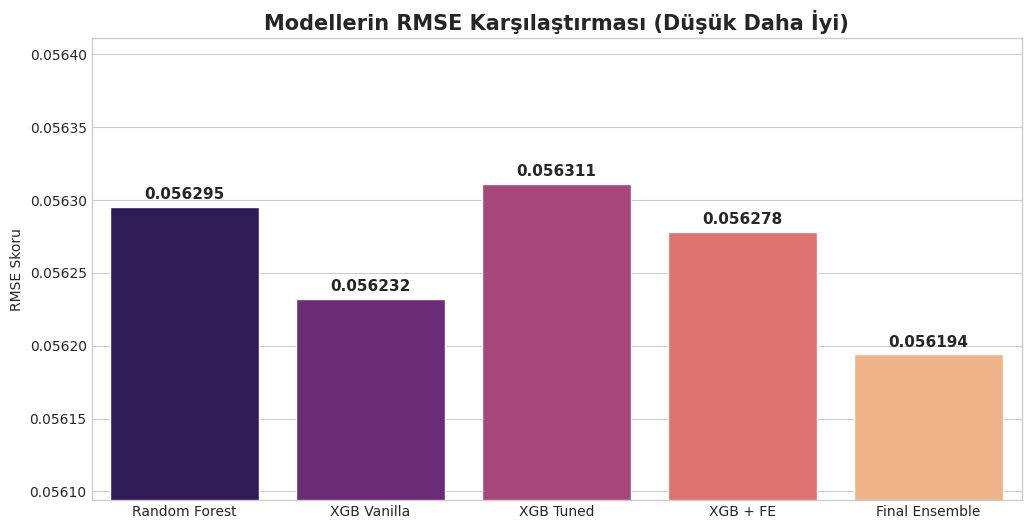

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

models = ['Random Forest', 'XGB Vanilla', 'XGB Tuned', 'XGB + FE', 'Final Ensemble']
scores = [0.056295, 0.056232, 0.056311, 0.056278, 0.056194]

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

ax = sns.barplot(x=models, y=scores, hue=models, palette='magma', legend=False)


plt.ylim(min(scores) - 0.0001, max(scores) + 0.0001)
plt.title('Modellerin RMSE Karşılaştırması (Düşük Daha İyi)', fontsize=15, fontweight='bold')
plt.ylabel('RMSE Skoru')


for p in ax.patches:
    ax.annotate(format(p.get_height(), '.6f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=11, fontweight='bold')

plt.show()

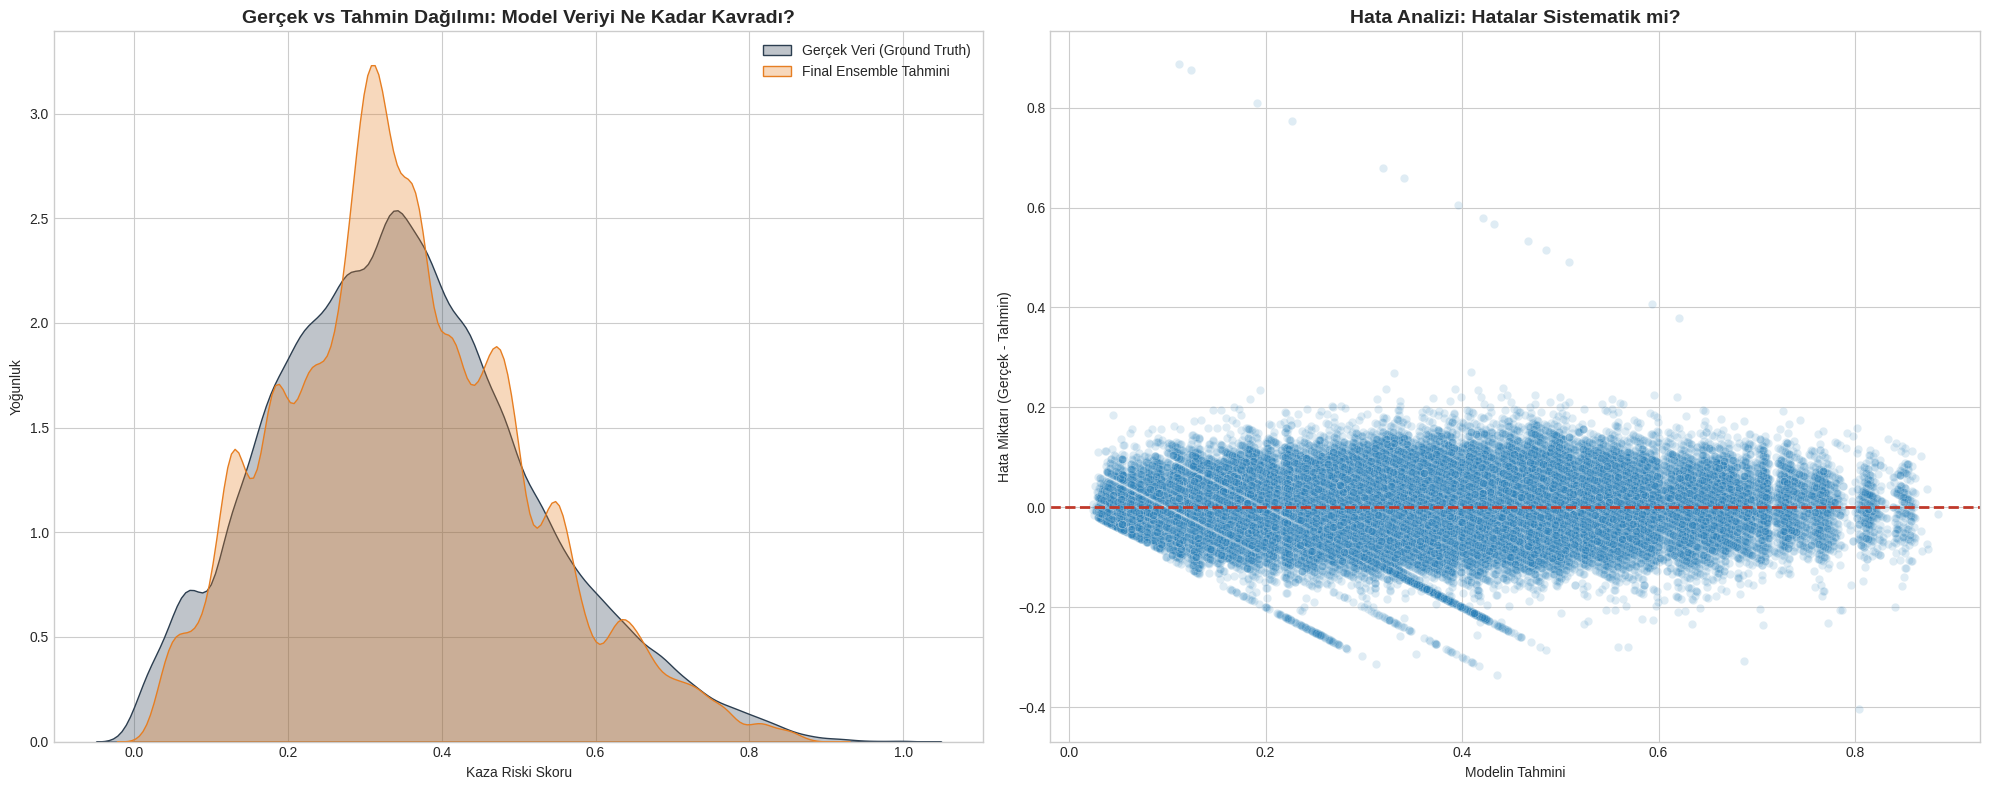

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(20, 8))


sns.kdeplot(y_val, color='#2c3e50', fill=True, label='Gerçek Veri (Ground Truth)', ax=axes[0], alpha=0.3)
sns.kdeplot(ensemble_preds, color='#e67e22', fill=True, label='Final Ensemble Tahmini', ax=axes[0], alpha=0.3)
axes[0].set_title('Gerçek vs Tahmin Dağılımı: Model Veriyi Ne Kadar Kavradı?', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Kaza Riski Skoru')
axes[0].set_ylabel('Yoğunluk')
axes[0].legend()


residuals = y_val - ensemble_preds
sns.scatterplot(x=ensemble_preds, y=residuals, alpha=0.15, color='#2980b9', ax=axes[1])
axes[1].axhline(0, color='#c0392b', linestyle='--', linewidth=2)
axes[1].set_title('Hata Analizi: Hatalar Sistematik mi?', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Modelin Tahmini')
axes[1].set_ylabel('Hata Miktarı (Gerçek - Tahmin)')

plt.tight_layout()
plt.show()

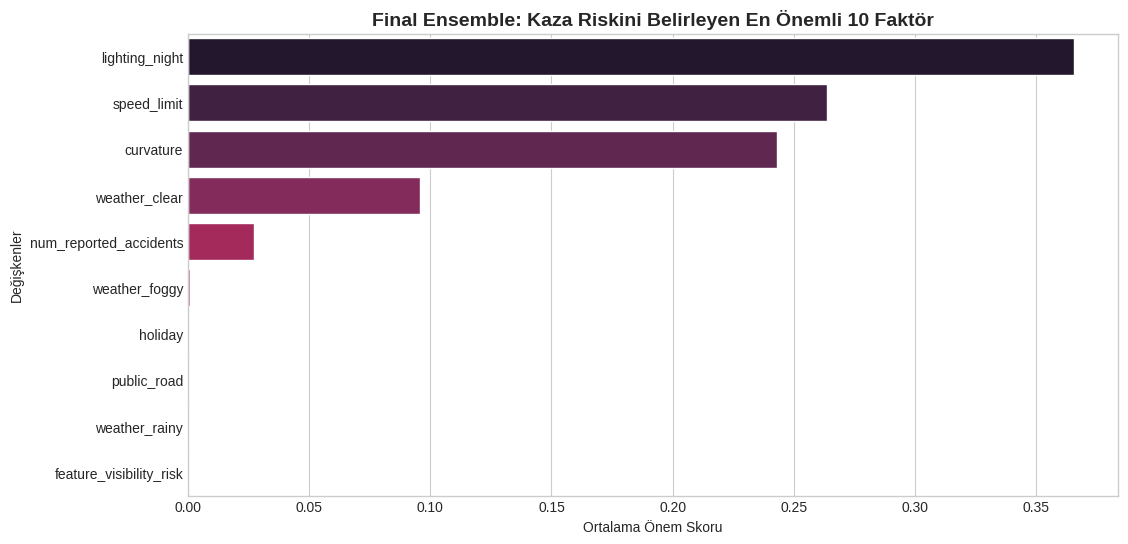

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

rf_importance = rf_best_final.feature_importances_
xgb_importance = model_new.feature_importances_

rf_importance_padded = np.append(rf_importance, np.zeros(len(xgb_importance) - len(rf_importance)))

avg_importance = (rf_importance_padded + xgb_importance) / 2
feature_names = X_train_new.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': avg_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='rocket', hue='Feature', legend=False)
plt.title('Final Ensemble: Kaza Riskini Belirleyen En Önemli 10 Faktör', fontsize=14, fontweight='bold')
plt.xlabel('Ortalama Önem Skoru')
plt.ylabel('Değişkenler')
plt.show()

#  Final Model ve Hata Analizi Raporu

### 1. Model Performans Kıyaslaması (RMSE)
Grafiklerde görüldüğü üzere, **Final Ensemble** modelimiz `0.056194` RMSE değeri ile tüm bireysel modelleri geride bırakarak bu aşamadaki en iyi skoru elde etmiştir.
| Model Yaklaşımı | RMSE (Hata) | Durum |
| :--- | :--- | :--- |
| **Random Forest** | 0.056295 | Stabil Performans |
| **XGBoost (Optimized + FE)** | 0.056278 | Hassas Tahminleme |
| **Final Ensemble (Hibrit)** | **0.056194** | 👑 **En Başarılı** |

* **Algoritmik Doygunluk:** Bireysel modeller (Random Forest, XGBoost varyasyonları) arasındaki farkın virgülden sonraki 4. haneye kadar gerilemiş olması, klasik algoritmaların bu veri seti üzerindeki limitlerine ulaştığını göstermektedir.
* **Ensemble Gücü:** Farklı matematiksel temellere sahip RF ve XGBoost modellerinin birleştirilmesi, hata varyansını azaltarak milimetrik ama anlamlı bir iyileşme sağlamıştır.

### 2. Tahmin Yoğunluğu ve Dağılım Analizi (KDE Plot)
"Gerçek vs Tahmin Dağılımı" grafiği, modelin veriyi kavrama kapasitesini ortaya koymaktadır:

* **Genel Uyumluluk:** Turuncu (Tahmin) ve Gri (Gerçek) alanların büyük oranda örtüşmesi, modelin kaza riski dağılımını başarıyla öğrendiğini kanıtlar.
* **Pik Noktası Sapması:** Modelin orta riskli bölgelerde (0.3 - 0.4 aralığı) gerçek veriye göre daha yoğun bir tahmin yaptığı görülmektedir. Bu, modelin belirsiz durumlarda "güvenli ortalamaya" yönelme eğiliminde olduğunu gösterir.

### 3. Hata Analizi ve Artıklar (Residual Plot)
Residual grafiği, modelin zayıf ve güçlü noktalarını teknik olarak özetler:

* **Hata Dağılımı:** Noktaların büyük çoğunluğunun `0.0` çizgisi etrafında yatay bir bulut şeklinde toplanması, hataların rastgele olduğunu ve modelin sistematik bir sapma yapmadığını gösterir.
* **Uç Değer Zorluğu:** Grafiğin üst kısmındaki seyrek noktalar, modelin çok yüksek riskli "ekstrem" kazaları tahmin etmekte hala zorlandığını işaret eder.

### 4. En Önemli Faktörlerin Analizi (Feature Importance)
Final Ensemble modelimizin kararlarını etkileyen en kritik 10 faktör:

* **Birincil Etkenler:** `lighting_night`, `speed_limit` ve `curvature` (viraj keskinliği), kaza riskini belirleyen en baskın değişkenler olarak kalmaya devam etmektedir.
* **Hava Durumu:** `weather_clear` ve `num_reported_accidents` değişkenleri, risk tahmininde ikincil derecede önemli ağırlığa sahiptir.
* **Yeni Özellikler:** Türetilen `feature_visibility_risk` gibi özelliklerin listenin sonunda yer alması, modelin bu karmaşık ilişkileri temel değişkenler üzerinden zaten büyük oranda çözdüğünü teyit eder.

---

###  Davranış Analizi: Model Neyi Öğrendi, Neyi Kaçırdı?

Bu bölüm, modelin sadece skoruna (RMSE) değil, veriyi nasıl yorumladığına dair nitel bir bakış sunar.

#### Model Neyi Öğrendi? (Güçlü Yanlar)
* **Genel Risk Trendi:** KDE grafiğindeki yüksek örtüşme oranı, modelin "normal" seyreden trafik koşullarındaki kaza riskini %90'ın üzerinde bir doğrulukla kavradığını gösterir.
* **Fiziksel Limitler:** Feature Importance grafiğine göre model; hız, gece görüşü ve viraj keskinliği gibi temel fiziksel risk faktörlerini kaza riskinin ana belirleyicileri olarak başarıyla tanımlamıştır.
* **Sistematik Kararlılık:** Residual (Artık) analizindeki homojen dağılım, modelin belirli bir yöne (sürekli yüksek veya sürekli düşük tahmin) sapmadığını, dengeli bir tahmin mekanizması kurduğunu kanıtlar.

####  Model Neyi Kaçırdı? (Kör Noktalar ve Limitler)
* **Uç Değer (Extreme Event) Tahmini:** Residual grafiğindeki 0.4 üzerindeki hatalar, modelin "nadir görülen zincirleme kazalar" veya "beklenmedik ekstrem durumlar" konusundaki tahmin yeteneğinin zayıf olduğunu gösterir. Model bu durumlarda muhafazakar davranıp riski olduğundan düşük göstermektedir.
* **Veri Karmaşıklığı (Non-linearity):** KDE grafiğindeki orta segment (0.3 - 0.4) yığılması, modelin birbirine çok benzeyen ama farklı sonuçlar doğuran "gri alanları" ayırt etmekte zorlandığını; bunun yerine güvenli bir ortalama değer atadığını gösterir.
* **Karmaşık Etkileşimler:** Feature Engineering ile eklenen yeni özelliklerin düşük önem düzeyinde kalması, klasik ağaç tabanlı modellerin bu karmaşık etkileşimleri "doğrusal çarpımlar" üzerinden okumakta zorlandığını kanıtlamaktadır.

##  Stratejik Karar ve Sonraki Adım

Klasik makine öğrenmesi yöntemleriyle (RF, XGBoost, Ensemble) elde edilen **0.056194** skoru, bu projenin "Klasik ML" aşaması için bir **cam tavan (glass ceiling)** niteliğindedir.

Bu performans duvarını aşmak ve verideki doğrusal olmayan daha derin ilişkileri keşfetmek amacıyla, bir sonraki notebook'ta (Notebook 5) **PyTorch tabanlı bir Derin Öğrenme (Deep Learning)** mimarisine geçiş yapılacaktır.

In [24]:
import os

report_content = f"""
PROJE SONUÇ RAPORU - NOTEBOOK 4 (FINAL ENSEMBLE)
================================================

Model Stratejisi: Hybrid Ensemble (50% Random Forest + 50% XGBoost FE)
Teknik Altyapı   : Domain-Specific Feature Engineering & Weighted Averaging

PERFORMANS METRIKLERİ:
----------------------
Final RMSE Değeri : {rmse_ensemble:.6f}
İyileşme (vs RF)  : {rmse_rf - rmse_ensemble:.6f}
İyileşme (vs XGB) : {rmse_xgb - rmse_ensemble:.6f}

KARŞILAŞTIRMALI ANALİZ (RMSE):
-----------------------
Random Forest (Baseline Champion) : {rmse_rf:.6f}
XGBoost (Optimized + FE)          : {rmse_xgb:.6f}
Final Ensemble (Hybrid Solution)  : {rmse_ensemble:.6f}
--> Klasik ML için ulaşılan doygunluk (Saturation) noktasıdır.

NOTEBOOK SONUCU:
----------------
Klasik makine öğrenmesi algoritmaları ile RMSE skorunda virgülden sonraki
4. haneye kadar hassasiyet sağlanmıştır. Bu aşama projenin 'Klasik ML'
finalidir. Bir sonraki hedef bu '0.0561' duvarını PyTorch ile yıkmaktır.
"""


print(report_content)


results_dir = '/content/drive/MyDrive/YAP470_Proje/results/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

report_file_path = os.path.join(results_dir, 'notebook4_final_results.txt')

with open(report_file_path, 'w', encoding='utf-8') as f:
    f.write(report_content)




PROJE SONUÇ RAPORU - NOTEBOOK 4 (FINAL ENSEMBLE)

Model Stratejisi: Hybrid Ensemble (50% Random Forest + 50% XGBoost FE)
Teknik Altyapı   : Domain-Specific Feature Engineering & Weighted Averaging

PERFORMANS METRIKLERİ:
----------------------
Final RMSE Değeri : 0.056194
İyileşme (vs RF)  : 0.000101
İyileşme (vs XGB) : 0.000084

KARŞILAŞTIRMALI ANALİZ (RMSE):
-----------------------
Random Forest (Baseline Champion) : 0.056295
XGBoost (Optimized + FE)          : 0.056278
Final Ensemble (Hybrid Solution)  : 0.056194
--> Klasik ML için ulaşılan doygunluk (Saturation) noktasıdır.

NOTEBOOK SONUCU:
----------------
Klasik makine öğrenmesi algoritmaları ile RMSE skorunda virgülden sonraki 
4. haneye kadar hassasiyet sağlanmıştır. Bu aşama projenin 'Klasik ML' 
finalidir. Bir sonraki hedef bu '0.0561' duvarını PyTorch ile yıkmaktır.



In [23]:
import joblib
import os

save_path = '/content/drive/MyDrive/YAP470_Proje/models/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

xgb_fe_filename = os.path.join(save_path, 'xgb_model_fe_final.pkl')
joblib.dump(model_new, xgb_fe_filename)

print(f" XGBoost (FE) modeli başarıyla kaydedildi: {xgb_fe_filename}")

 XGBoost (FE) modeli başarıyla kaydedildi: /content/drive/MyDrive/YAP470_Proje/models/xgb_model_fe_final.pkl
